<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/1-Image%20Classification%20(cats%20VS%20dogs)/seedPlant/plantSeeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
%cd /content/drive/MyDrive/plantSeed

[Errno 2] No such file or directory: '/content/drive/MyDrive/plantSeed'
/content/drive/MyDrive/plantSeed/drive


In [69]:
%ls

kaggle.json  sample_submission.csv  test/  train/  valid/


In [70]:
pwd

'/content/drive/MyDrive/dogVsCat/plantSeed/drive'

In [71]:
#!pip3 install bcolz 

In [72]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

#Kaggle

In [73]:
#pip install kaggle

In [74]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/plantSeed/drive"

In [75]:
#Change your present working directory
%cd /content/drive/MyDrive/plantSeed/drive

[Errno 2] No such file or directory: '/content/drive/MyDrive/plantSeed/drive'
/content/drive/MyDrive/plantSeed/drive


In [76]:
pwd

'/content/drive/MyDrive/dogVsCat/plantSeed/drive'

## download dataset from kaggle

In [77]:
'''	!pip uninstall -y kaggle
  !pip install --upgrade pip
  !pip install kaggle==1.5.6'''

'\t!pip uninstall -y kaggle\n  !pip install --upgrade pip\n  !pip install kaggle==1.5.6'

In [78]:
#copy API from dataset section in kaggle website
#!kaggle competitions download -c plant-seedlings-classification

In [79]:
!ls

kaggle.json  sample_submission.csv  test  train  valid


In [80]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [81]:
!ls

kaggle.json  sample_submission.csv  test  train  valid


In [82]:
DATA_DIR ='/content/drive/MyDrive/plantSeed/drive/'

sz = 224
batch_size = 16

In [83]:
#os.listdir(DATA_DIR)

In [84]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [85]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

[]

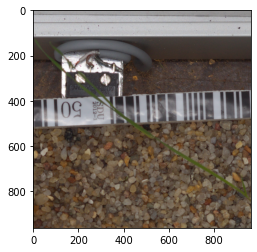

In [24]:
img = plt.imread(trn_fnames[17])
plt.imshow(img);

# Datasets and Dataloaders in PyTorch

- Dataset
A set of images.
- Dataloader
Loads data from dataset behind the scene using concurrent threads.

In [25]:
train_ds = datasets.ImageFolder(trn_dir)

In [26]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [27]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

# create validation data

In [62]:
#! pip install tensorflow --upgrade
#import keras
from keras_preprocessing.image import ImageDataGenerator
!pip list | grep -i keras
import keras_preprocessing

Keras                         2.4.3
keras-nightly                 2.5.0.dev2021032900
Keras-Preprocessing           1.1.2
keras-vis                     0.4.1


In [66]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    trn_dir,
    target_size=(sz, sz),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)


FileNotFoundError: ignored